# House Prices: Advanced Regression Techniques
Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.

_Source: [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)_

## Table of Contents <a name='table'></a>
- [Load Data](#Load-Data)
- [Find 'Na' Values](#na)
  - [Explore 'Na' Values](#cleanNa)
  - [Fill 'Na' Values](#fillNa)

***

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load Data <a name='Load-Data'></a>
[Table of Cotents](#table)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.shape

(1460, 81)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Find 'NA' Values <a name ='findNa'></a>
[Table of Contents](#table)

<AxesSubplot:>

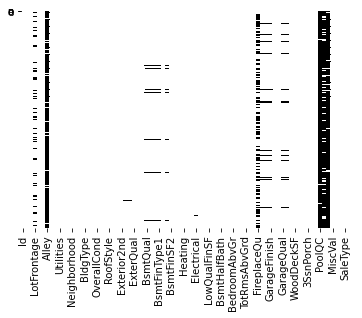

In [5]:
sns.heatmap(train_data.isna(),cmap='binary', cbar=False, yticklabels='none')

In [6]:
na_sum = train_data.isna().sum().sort_values(ascending=False)
print(na_sum.loc[na_sum >= 1])
print(f'Columns with NaN values: {na_sum.loc[na_sum >= 1].count()}')

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64
Columns with NaN values: 19


In [7]:
X_train = train_data.copy()

In [8]:
na_find = X_train.isna().any()
na_values = X_train.loc[:,na_find]
na_col = na_values.columns.tolist()

# train_data.fillna(value=1, axis=1, inplace = True)
# train_data.isna().any()

### Clean 'Na' Values <a name='cleanNa'></a>
[Table of Contents](#table)

In [9]:
na_ratio = na_sum / len(X_train)
na_ratio.sort_values(ascending=False)[:19]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtCond        0.025342
BsmtQual        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

In [10]:
na_col

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

Dropping columns with over 30% na values.
May come back and turn them into valuable features later.

In [11]:
na_drop = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
X_train.drop(na_drop, axis=1, inplace=True)

for i in na_drop:
    na_col.remove(i)

In [12]:
na_mean =[]
na_median =[]
na_mode =[]

def na_sort(column, sort):
    if column not in na_col:
        return "Column doesn't contain 'Na' values."
        
    elif sort == 'mean':
        na_mean.append(column)
    elif sort == 'median':
        na_median.append(column)
    elif sort == 'mode':
        na_mode.append(column)
    else:
        return 'Unkown sort value'
    
    na_col.remove(column)
    
    print(na_col)
    print(f'Remaining columns w/ "NA" values {len(na_col)}')
    
    return

In [13]:
def scribe_stats(column, df=X_train):
    if df[column].dtype == 'O':
        df[column].value_counts(normalize=True).plot(kind='bar')
        
        print(df[column].describe())
        print(f'"Na" value count: {df[column].isna().sum()}')
        print(f'"Na" % missing: {df[column].isna().sum() / len(df[column])}')

    else:
        plt.subplots(1,2, figsize=(12,4))
        
        plt.subplot(1,2,1)
        df[column].hist()
        
        plt.subplot(1,2,2)
        df[column].plot(kind='box')
        
        print(f'Median: {df[column].median()},\nMode: {df[column].mode()}, \
        \nSkew: {df[column].skew()}, \nKurtosis: {df[column].kurtosis()}, \
        \n{df[column].describe()} \n"Na" value count: {df[column].isna().sum()} ')
    return

In [14]:
na_col

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

Median: 69.0,
Mode: 0    60.0
dtype: float64,         
Skew: 2.163569142324884, 
Kurtosis: 17.452867259818404,         
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64 
"Na" value count: 259 


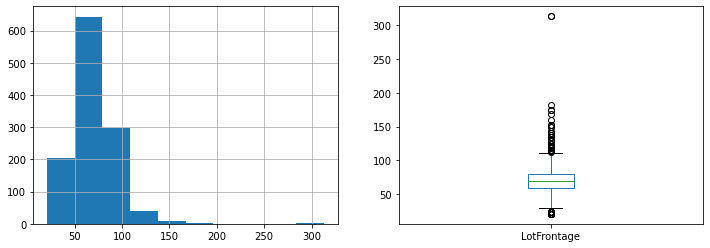

In [15]:
scribe_stats('LotFrontage')

In [16]:
na_sort('LotFrontage','mean')

['MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 13


count     1452
unique       4
top       None
freq       864
Name: MasVnrType, dtype: object
"Na" value count: 8
"Na" % missing: 0.005479452054794521


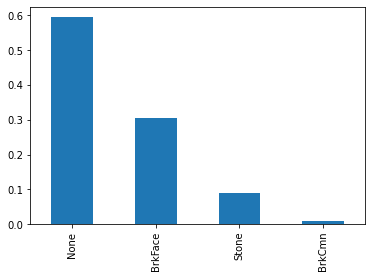

In [17]:
scribe_stats('MasVnrType')

In [18]:
na_sort('MasVnrType', 'mode')

['MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 12


Median: 0.0,
Mode: 0    0.0
dtype: float64,         
Skew: 2.669084210182863, 
Kurtosis: 10.08241731736711,         
count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64 
"Na" value count: 8 


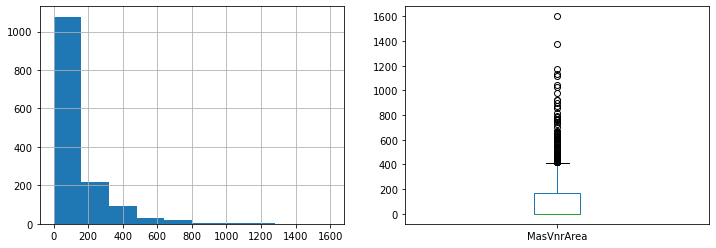

In [19]:
scribe_stats('MasVnrArea')

In [20]:
na_sort('MasVnrArea', 'mean')

['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 11


count     1423
unique       4
top         TA
freq       649
Name: BsmtQual, dtype: object
"Na" value count: 37
"Na" % missing: 0.025342465753424658


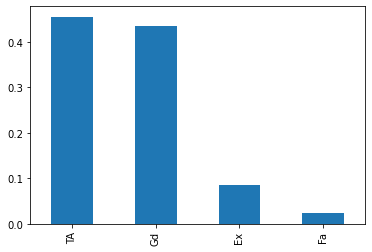

In [21]:
scribe_stats('BsmtQual')

In [22]:
na_sort('BsmtQual', 'mode')

['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 10


count     1423
unique       4
top         TA
freq      1311
Name: BsmtCond, dtype: object
"Na" value count: 37
"Na" % missing: 0.025342465753424658


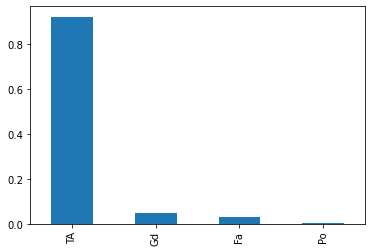

In [23]:
scribe_stats('BsmtCond')

In [24]:
na_sort('BsmtCond', 'mode')

['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 9


count     1422
unique       4
top         No
freq       953
Name: BsmtExposure, dtype: object
"Na" value count: 38
"Na" % missing: 0.026027397260273973


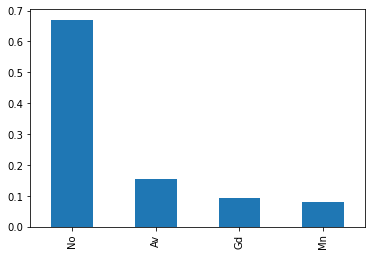

In [25]:
scribe_stats('BsmtExposure')

In [26]:
na_sort('BsmtExposure','mode')

['BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 8


count     1423
unique       6
top        Unf
freq       430
Name: BsmtFinType1, dtype: object
"Na" value count: 37
"Na" % missing: 0.025342465753424658


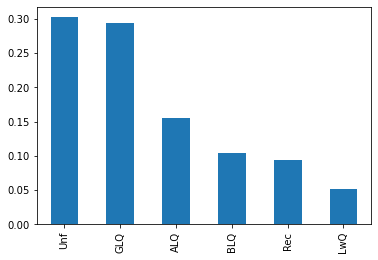

In [27]:
scribe_stats('BsmtFinType1')

In [28]:
na_sort('BsmtFinType1','mode')

['BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 7


count     1422
unique       6
top        Unf
freq      1256
Name: BsmtFinType2, dtype: object
"Na" value count: 38
"Na" % missing: 0.026027397260273973


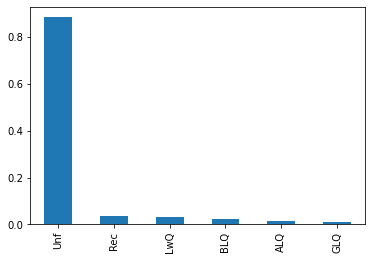

In [29]:
scribe_stats('BsmtFinType2')

In [30]:
na_sort('BsmtFinType2','mode')

['Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 6


count      1459
unique        5
top       SBrkr
freq       1334
Name: Electrical, dtype: object
"Na" value count: 1
"Na" % missing: 0.0006849315068493151


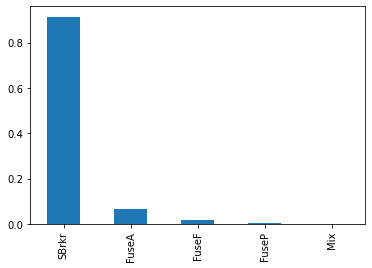

In [31]:
scribe_stats('Electrical')

In [32]:
na_sort('Electrical','mode')

['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 5


count       1379
unique         6
top       Attchd
freq         870
Name: GarageType, dtype: object
"Na" value count: 81
"Na" % missing: 0.05547945205479452


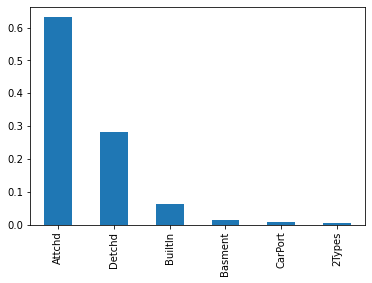

In [33]:
scribe_stats('GarageType')

In [34]:
na_sort('GarageType','mode')

['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 4


Median: 1980.0,
Mode: 0    2005.0
dtype: float64,         
Skew: -0.6494146238714679, 
Kurtosis: -0.4183409979729644,         
count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64 
"Na" value count: 81 


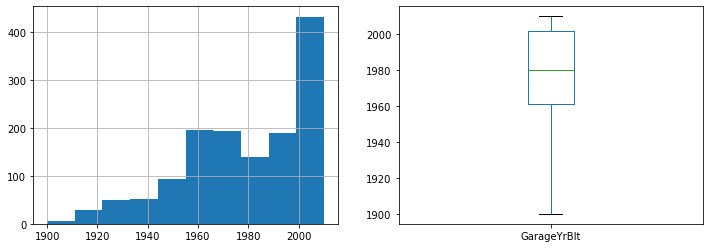

In [35]:
scribe_stats('GarageYrBlt')

In [36]:
na_sort('GarageYrBlt','mean')

['GarageFinish', 'GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 3


count     1379
unique       3
top        Unf
freq       605
Name: GarageFinish, dtype: object
"Na" value count: 81
"Na" % missing: 0.05547945205479452


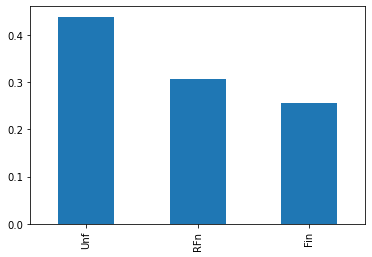

In [37]:
scribe_stats('GarageFinish')

In [38]:
na_sort('GarageFinish','mode')

['GarageQual', 'GarageCond']
Remaining columns w/ "NA" values 2


count     1379
unique       5
top         TA
freq      1311
Name: GarageQual, dtype: object
"Na" value count: 81
"Na" % missing: 0.05547945205479452


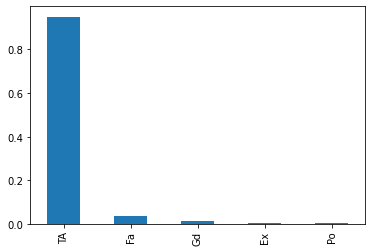

In [39]:
scribe_stats('GarageQual')

In [40]:
na_sort('GarageQual','mode')

['GarageCond']
Remaining columns w/ "NA" values 1


count     1379
unique       5
top         TA
freq      1326
Name: GarageCond, dtype: object
"Na" value count: 81
"Na" % missing: 0.05547945205479452


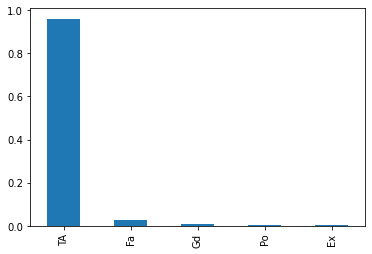

In [41]:
scribe_stats('GarageCond')

In [42]:
na_sort('GarageCond','mode')

[]
Remaining columns w/ "NA" values 0


In [43]:
def cont_scatter(df, compare, sale_price=train_data.SalePrice):
    
    plt.figure(figsize=(16,4))
    
    plt.subplot(1,3,1)
    plt.hist(df[compare])
    
    plt.subplot(1,3,2)
    plt.scatter(df[compare], sale_price)
    
    plt.subplot(1,3,3)
    plt.boxplot(df[compare])
    print(f'Median: {df[compare].median()},\nMode: {df[compare].mode()}, \
    \nSkew: {df[compare].skew()}, \nKurtosis: {df[compare].kurtosis()}, \n{df[compare].describe()}')
    
    return

Median: 9478.5,
Mode: 0    7200
dtype: int64,     
Skew: 12.207687851233496, 
Kurtosis: 203.24327101886033, 
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64


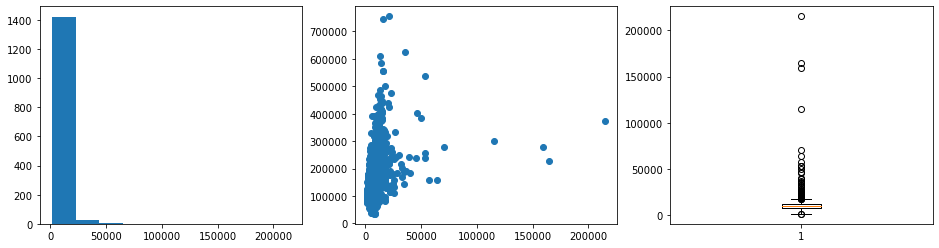

In [44]:
cont_scatter(train_data,'LotArea')

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

### Pipeline <a name='Pipeline'></a>
[Table of Contents](#table)

In [46]:
# mean = X_train[na_mean].mean()
# mean_fill = X_train[na_mean].fillna(mean)

# mode = X_train[na_mode].mode()
# X_train[na_mode].fillna(mode, inplace=True)
# **X_train[na_mode] = X_train[na_mode].fillna((X_train[na_mode].mode()))
X_train.isna().sum().sort_values(ascending=False)[:14]

LotFrontage      70.049958
MasVnrArea      103.685262
GarageYrBlt    1978.506164
dtype: float64


C:\Users\Brian\miniconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


LotFrontage     259
GarageFinish     81
GarageType       81
GarageCond       81
GarageQual       81
GarageYrBlt      81
BsmtExposure     38
BsmtFinType2     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrType        8
MasVnrArea        8
Electrical        1
dtype: int64

In [47]:
# X_train[na_mean] = X_train[na_mean].fillna((X_train[na_mean].mean()))

In [49]:
X_train.isna().sum().sort_values(ascending=False)[:14]

GarageQual      81
GarageType      81
GarageFinish    81
GarageCond      81
BsmtExposure    38
BsmtFinType2    38
BsmtFinType1    37
BsmtCond        37
BsmtQual        37
MasVnrType       8
Electrical       1
RoofStyle        0
RoofMatl         0
Exterior1st      0
dtype: int64

In [50]:
y_train = X_train.SalePrice
X_train.drop(axis=1,columns='SalePrice',inplace=True)

In [51]:
cat_labels = X_train.select_dtypes(include='object').columns.tolist()

In [52]:
mean_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean',verbose=1)),
])

In [53]:
mode_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent',verbose=1)),
])

In [54]:
full_pipeline = ColumnTransformer([
    ('na_mean', mean_pipeline, na_mean),
    ('na_mode', mode_pipeline, na_mode),
    ('cat', OneHotEncoder(), cat_labels),
])

In [55]:
full_pipeline

ColumnTransformer(transformers=[('na_mean',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(verbose=1))]),
                                 ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']),
                                ('na_mode',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent',
                                                                verbose=1))]),
                                 ['MasVnrType', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Electrical', 'GarageType',
                                  'GarageFin...
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Neighborhood', 'Condition1',
                                  'Condition2'

In [56]:
X = full_pipeline.fit(X_train)

ValueError: Input contains NaN

In [ ]:
# one_hot = OneHotEncoder()
# testx = X_train
# testx.dropna(inplace=True)
# one_hot.categories_

In [ ]:
clf = LinearRegression()
clf.fit(X,y_train)

In [ ]:
np.isfinite(X_train)